# 1. Import Libraries

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

# 2. Datasets & DataLoaders

In [5]:
# Download training data from open datasets.
training_data = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor(),)

# Download test data from open datasets.
validation_data = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor(),)

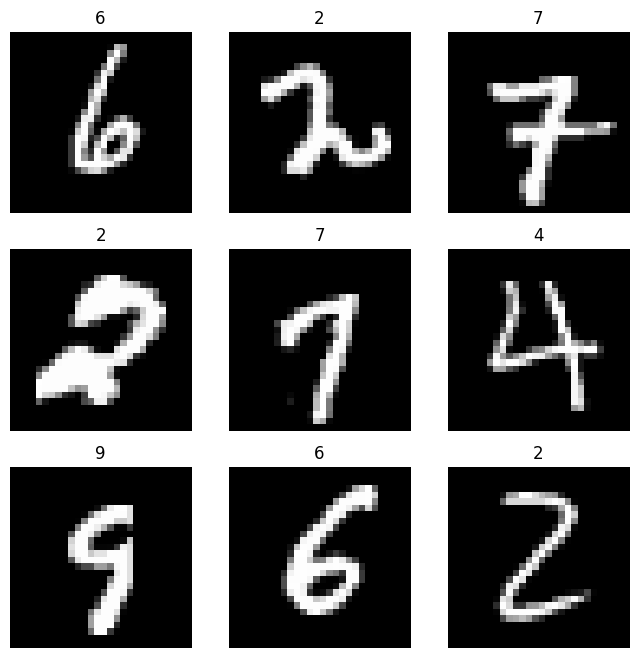

In [6]:
# Iterating and Visualizing the Dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [8]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


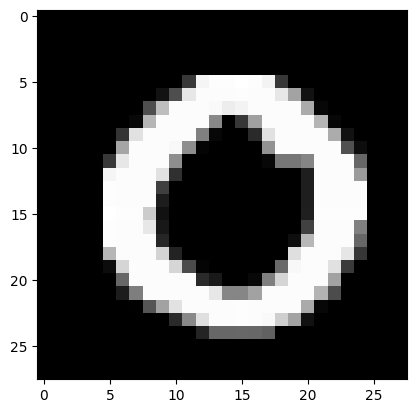

Label: 0


In [9]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# 3. Build Model

In [10]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [11]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential( #layers increase -> need more data -> overfitting
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits #prediction value

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# 4. Optimizing the Model Parameters

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [13]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [15]:
# Check the model's performance against the test dataset to ensure it is learning
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [16]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(validation_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303289  [   64/60000]
loss: 2.302846  [ 6464/60000]
loss: 2.305627  [12864/60000]
loss: 2.301228  [19264/60000]
loss: 2.282423  [25664/60000]
loss: 2.291875  [32064/60000]
loss: 2.287501  [38464/60000]
loss: 2.275088  [44864/60000]
loss: 2.268726  [51264/60000]
loss: 2.261827  [57664/60000]
Test Error: 
 Accuracy: 35.3%, Avg loss: 2.261835 

Epoch 2
-------------------------------
loss: 2.260186  [   64/60000]
loss: 2.259143  [ 6464/60000]
loss: 2.250021  [12864/60000]
loss: 2.252672  [19264/60000]
loss: 2.247503  [25664/60000]
loss: 2.243957  [32064/60000]
loss: 2.234969  [38464/60000]
loss: 2.221015  [44864/60000]
loss: 2.203775  [51264/60000]
loss: 2.225042  [57664/60000]
Test Error: 
 Accuracy: 59.2%, Avg loss: 2.200548 

Epoch 3
-------------------------------
loss: 2.204772  [   64/60000]
loss: 2.193841  [ 6464/60000]
loss: 2.181355  [12864/60000]
loss: 2.183987  [19264/60000]
loss: 2.172407  [25664/60000]
loss: 2.165563  [32064/600

# 5. Saving Models

In [17]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


# 6. Loading Model and Making prediction

In [19]:
# Re-creating the model structure and load the state dictionary into it.
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

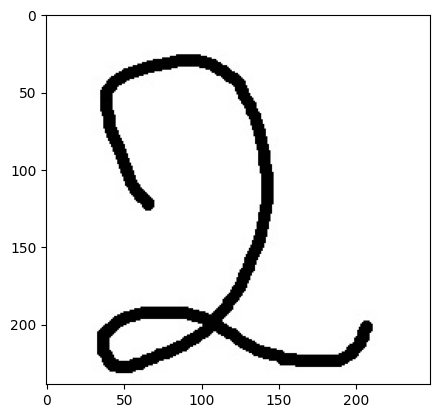

Predicted class: 0


In [24]:
# Load and preprocess the image
image = Image.open("/content/Screenshot 2024-05-23 011923.png")

# Define transformations
preprocess = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize image to fit model input size
    transforms.Grayscale(),       # Convert image to grayscale
    transforms.ToTensor(),         # Convert image to tensor
])

# Apply transformations
input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
input_tensor = torch.flatten(input_tensor, start_dim=1)  # Flatten tensor
plt.imshow(image, cmap="gray")
plt.show()
# Predict
with torch.no_grad():
    output = model(input_tensor)

# Get predicted class
predicted_class = torch.argmax(output).item()
print("Predicted class:", predicted_class)
